In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import missingno as msno 

In [34]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
submission = pd.read_csv('./output/sample_submission.csv')

In [35]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

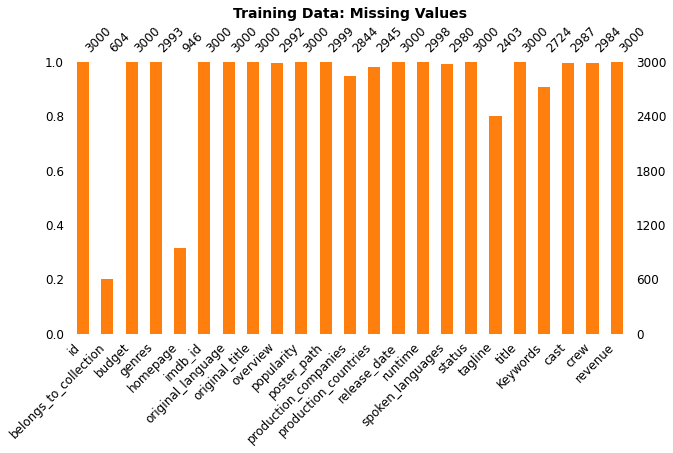

In [37]:
train_miss = msno.bar(train, figsize=(10, 5), fontsize=12, color='C1').set_title('Training Data: Missing Values', fontweight='bold', fontsize=14)

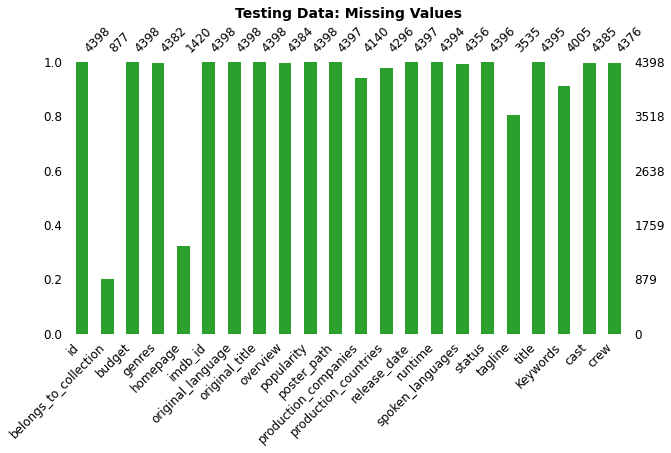

In [38]:
test_miss = msno.bar(test, figsize=(10, 5), fontsize=12, color='C2').set_title('Testing Data: Missing Values', fontweight='bold', fontsize=14)

In [39]:
test[test['release_date'].isnull()]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
828,3829,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,NaN,NaN,90.0,NaN,NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN


In [40]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '5/1/00'
test[test['release_date'] == '5/1/00']

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
828,3829,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,NaN,5/1/00,90.0,NaN,NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN
1731,4732,NaN,103000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0172495,en,Gladiator,"In the year 180, the death of emperor Marcus A...",23.186667,/6WBIzCgmDCYrqh64yDREGeDk9d3.jpg,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",5/1/00,155.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Hero Will Rise.,Gladiator,"[{'id': 588, 'name': 'rome'}, {'id': 1394, 'na...","[{'cast_id': 8, 'character': 'Maximus', 'credi...","[{'credit_id': '52fe4217c3a36847f800340d', 'de..."


In [41]:
train[['genres',
       'original_language', 
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = train[['genres',
         'original_language', 
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

test[['genres',
       'original_language', 
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = test[['genres',
         'original_language', 
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

In [42]:
train['runtime'] = train['runtime'].fillna(train['runtime'].mean())
test['runtime'] = test['runtime'].fillna(train['runtime'].mean())
train['runtime'].isnull().any()

False

In [43]:
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')

train["release_year"] = pd.to_datetime(train["release_date"]).dt.year.astype(int)
train["release_day"] = pd.to_datetime(train["release_date"]).dt.dayofweek.astype(int)
train["release_month"] = pd.to_datetime(train["release_date"]).dt.month.astype(int)
test["release_year"] = pd.to_datetime(test["release_date"]).dt.year.astype(int)
test["release_day"] = pd.to_datetime(test["release_date"]).dt.dayofweek.astype(int)
test["release_month"] = pd.to_datetime(test["release_date"]).dt.month.astype(int)

In [44]:
train['release_year'].max()

2068

In [45]:
def fix_date(x):
    if x > 2019:
        return x - 100
    else:
        return x

In [46]:
train['release_year'] = train['release_year'].apply(lambda x: fix_date(x))
test['release_year'] = test['release_year'].apply(lambda x: fix_date(x))

<AxesSubplot:>

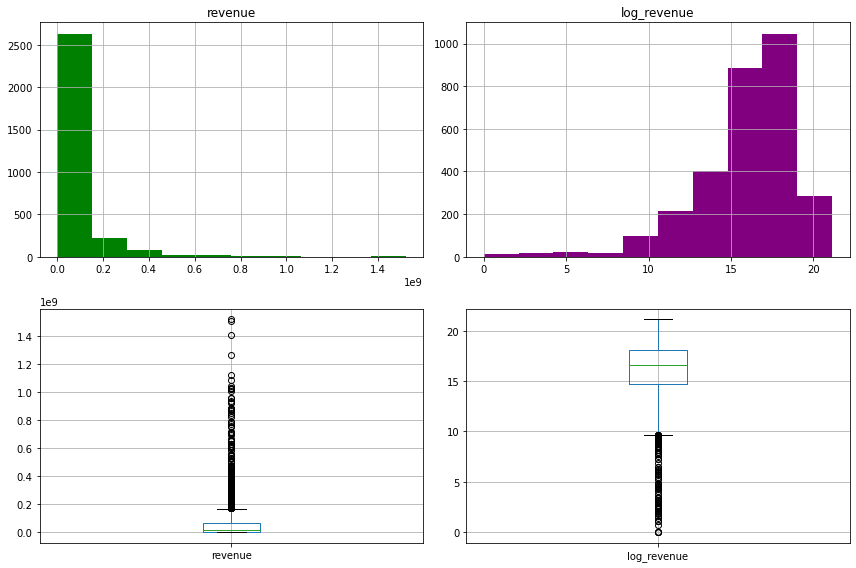

In [47]:
train['log_revenue'] = np.log(train['revenue'])

fig, ax = plt.subplots(2, 2, figsize=(12,8), tight_layout=True)
train.hist(column=['revenue'], ax=ax[0][0], color='green')
train.hist(column=['log_revenue'], ax=ax[0][1], color='purple')

train.boxplot(column=['revenue'], ax=ax[1][0])
train.boxplot(column=['log_revenue'], ax=ax[1][1])

<AxesSubplot:>

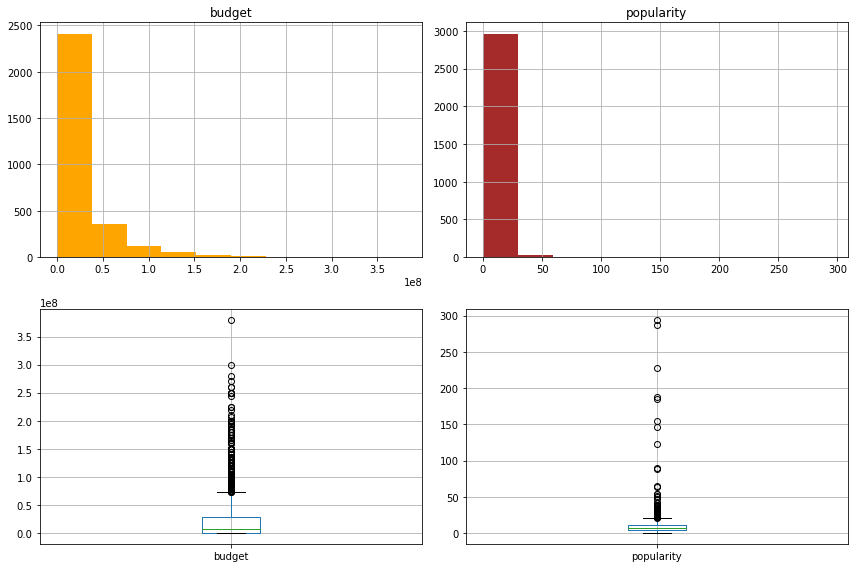

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

train.hist(column= ["budget"], ax=ax[0][0], color='orange')
train.hist(column= ['popularity'], ax=ax[0][1], color='brown')
train.boxplot(column= ['budget'], ax=ax[1][0])
train.boxplot(column= ['popularity'], ax=ax[1][1])

<AxesSubplot:>

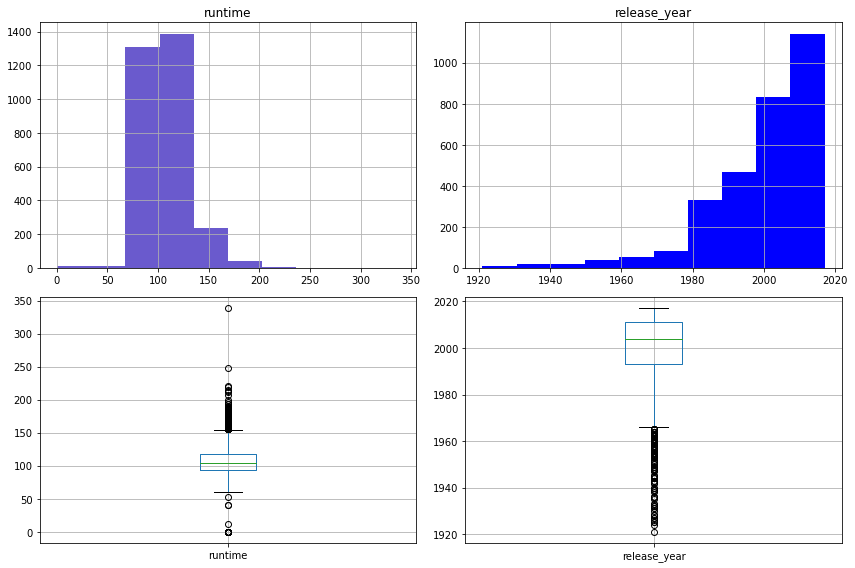

In [49]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8), tight_layout=True)

train.hist(column= ["runtime"], ax=ax[0][0], color='slateblue')
train.hist(column= ['release_year'], ax=ax[0][1], color='blue')
train.boxplot(column= ['runtime'], ax=ax[1][0])
train.boxplot(column= ['release_year'], ax=ax[1][1])

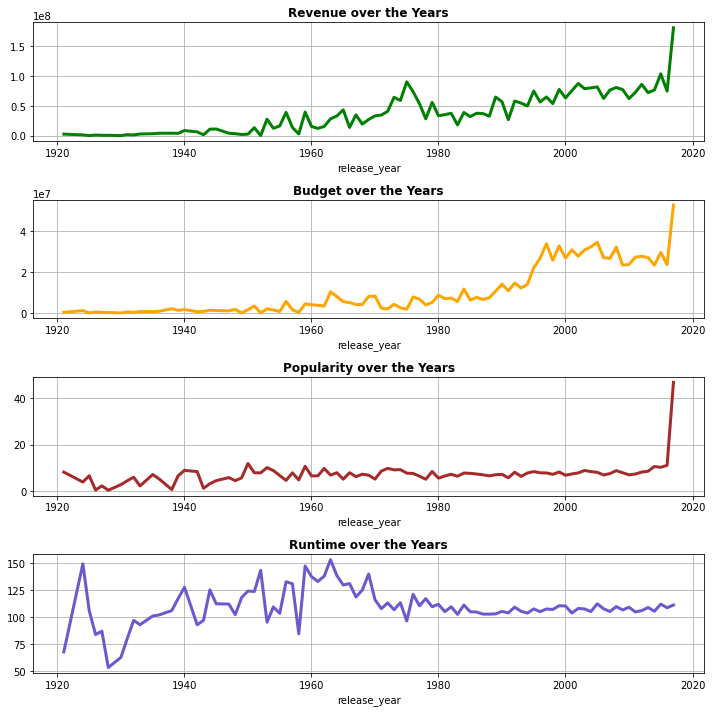

In [50]:
fig, ax = plt.subplots(4, 1, tight_layout=True)
plt.grid()

train.groupby('release_year')['revenue'].mean().plot(
    ax=ax[0],figsize=(10, 10), linewidth=3, color='green').set_title(
        'Revenue over the Years', fontweight="bold")

ax[0].grid()

train.groupby('release_year')['budget'].mean().plot(
    ax=ax[1], figsize=(10, 10), linewidth=3, color='orange').set_title(
        'Budget over the Years', fontweight="bold")

ax[1].grid()

train.groupby('release_year')['popularity'].mean().plot(
    ax=ax[2], figsize=(10, 10), linewidth=3, color='brown').set_title(
        'Popularity over the Years', fontweight="bold")

ax[2].grid()

train.groupby('release_year')['runtime'].mean().plot(
    ax=ax[3], figsize=(10, 10), linewidth=3, color='slateblue').set_title(
        'Runtime over the Years', fontweight="bold")
        
ax[3].grid()

fig.tight_layout(pad=2.0)
plt.show()

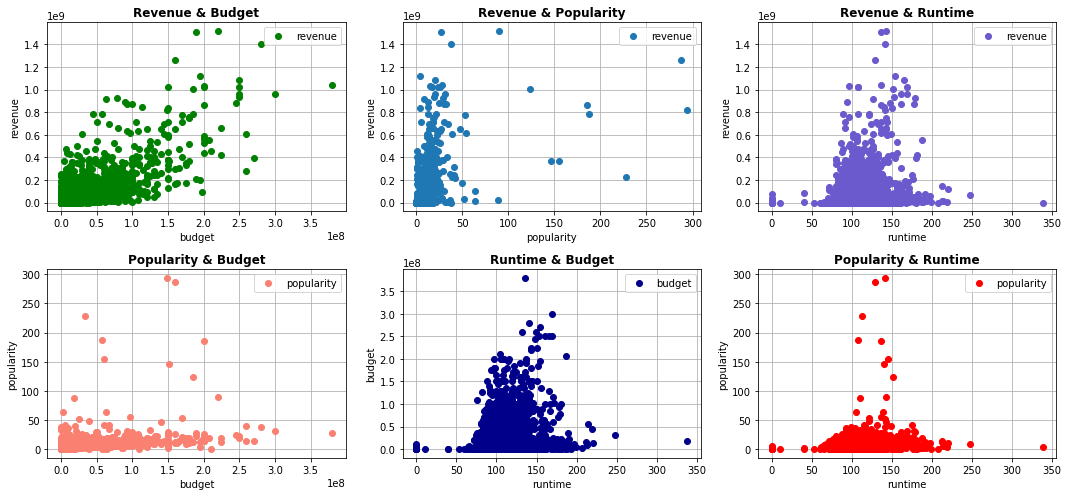

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), tight_layout=True)

train.plot(ax=ax[0][0], x='budget', y='revenue', style='o',ylabel= 'revenue', color='green').set_title(
    'Revenue & Budget', fontweight="bold")

ax[0][0].grid()

train.plot(ax=ax[0][1], x='popularity', y='revenue', style='o', ylabel= 'revenue').set_title(
    'Revenue & Popularity', fontweight="bold")

ax[0][1].grid()

train.plot(ax=ax[0][2], x='runtime', y='revenue', style='o', ylabel= 'revenue', color='slateblue').set_title(
    'Revenue & Runtime', fontweight="bold")

ax[0][2].grid()

train.plot(ax=ax[1][0], x='budget', y='popularity', style='o', ylabel= 'popularity', color='salmon').set_title(
    'Popularity & Budget', fontweight="bold")

ax[1][0].grid()

train.plot(ax=ax[1][1], x='runtime', y='budget', style='o', ylabel= 'budget', color='DarkBlue').set_title(
    'Runtime & Budget', fontweight="bold")

ax[1][1].grid()

train.plot(ax=ax[1][2], x='runtime', y='popularity', style='o', ylabel= 'popularity', color='red').set_title(
    'Popularity & Runtime', fontweight="bold")
    
ax[1][2].grid()

fig.tight_layout(pad=4.0)
plt.show()

In [52]:
for e in enumerate(test['genres'][:10]):
    print(e)

(0, "[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}]")
(1, "[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]")
(2, "[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]")
(3, "[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}, {'id': 9648, 'name': 'Mystery'}]")
(4, "[{'id': 36, 'name': 'History'}, {'id': 99, 'name': 'Documentary'}]")
(5, "[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]")
(6, "[{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]")
(7, "[{'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}]")
(8, "[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]")
(9, "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]")


In [53]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

In [54]:
train.genres = train.genres.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

train.spoken_languages = train.spoken_languages.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

train.cast = train.cast.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

train.crew = train.crew.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

test.genres = test.genres.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

test.spoken_languages = test.spoken_languages.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

test.cast = test.cast.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

test.crew = test.crew.map(
    lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(
        lambda x: ','.join(map(str, x)))

train.crew.head()

0    Adam Blum,Allison Gordin,Andrew Panay,Annabell...
1    Bruce Green,Charles Minsky,Debra Martin Chase,...
2    Alicia Hadaway,Andy Ross,Barbara Harris,Ben Wi...
3                  Sujoy Ghosh,Sujoy Ghosh,Sujoy Ghosh
4                        Jong-seok Yoon,Jong-seok Yoon
Name: crew, dtype: object

In [55]:
train['genres_count'] = train['genres'].str.count(',') + 1
train['spoken_languages_count'] = train['spoken_languages'].str.count(',') + 1
train['cast_count'] = train['cast'].str.count(',') + 1
train['crew_count'] = train['crew'].str.count(',') + 1

test['genres_count'] = test['genres'].str.count(',') + 1
test['spoken_languages_count'] = test['spoken_languages'].str.count(',') + 1
test['cast_count'] = test['cast'].str.count(',') + 1
test['crew_count'] = test['crew'].str.count(',') + 1
test['genres_count']

0       4
1       2
2       2
3       3
4       2
       ..
4393    1
4394    4
4395    1
4396    2
4397    1
Name: genres_count, Length: 4398, dtype: int64

In [56]:
train[['status', 
      'original_language', 
      'production_companies', 
      'production_countries']] = train[['status', 
               'original_language', 
               'production_companies',
               'production_countries']].astype('category')

train['status'] = train['status'].cat.codes
train['original_language'] = train['original_language'].cat.codes
train['production_companies'] = train['production_companies'].cat.codes
train['production_countries'] = train['production_countries'].cat.codes

test[['status', 
      'original_language', 
      'production_companies', 
      'production_countries']] = test[['status', 
               'original_language', 
               'production_companies',
               'production_countries']].astype('category')

test['status'] = test['status'].cat.codes
test['original_language'] = test['original_language'].cat.codes
test['production_companies'] = test['production_companies'].cat.codes
test['production_countries'] = test['production_countries'].cat.codes

train['production_countries']

0       316
1       316
2       316
3       210
4       236
       ... 
2995    316
2996    111
2997    316
2998    316
2999    316
Name: production_countries, Length: 3000, dtype: int16

In [57]:
train['budget'] = train['budget'].replace(0, train['budget'].mean())
train['runtime'] = train['runtime'].replace(0, train['runtime'].mean())

test['budget'] = test['budget'].replace(0, test['budget'].mean())
test['runtime'] = test['runtime'].replace(0, test['runtime'].mean())

In [58]:
X = train.drop(['log_revenue', 'revenue'], axis=1)
y = train['log_revenue']

In [59]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2,random_state=0)

In [60]:
feature_names = ['release_year', 'release_day', 'release_month', 'status', 'original_language',
                 'budget', 'popularity', 'genres_count', 'production_companies', 'production_countries',
                'spoken_languages_count', 'cast_count', 'crew_count', 'runtime']

# Assigning the data corresponding to features in feature_names
X_train_full = X_train_full[feature_names]

X_valid_full = X_valid_full[feature_names]

X_train_full.head()

,release_year,release_day,release_month,status,original_language,budget,popularity,genres_count,production_companies,production_countries,spoken_languages_count,cast_count,crew_count,runtime
2370,2012,1,3,0,7,150000000.0,7.739904,1,1012,121,1,18,31,99.0
1774,2001,4,10,0,7,35000000.0,7.790140,3,1997,80,3,26,65,122.0
731,1967,6,12,0,7,4000000.0,5.032469,3,1712,316,1,18,25,108.0
271,2006,4,8,0,7,72500000.0,6.936688,1,385,316,1,24,14,116.0
1077,1980,4,8,0,7,20000000.0,3.782547,3,2168,316,1,19,15,96.0


In [61]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_full, y_train)

RandomForestRegressor(random_state=42)

In [62]:
y_pred_rf = rf_model.predict(X_valid_full)

In [63]:
mae_rf = mean_absolute_error(y_pred_rf, y_valid)

print('MAE RF: ', mae_rf)

MAE RF:  1.3951502051422637


<AxesSubplot:>

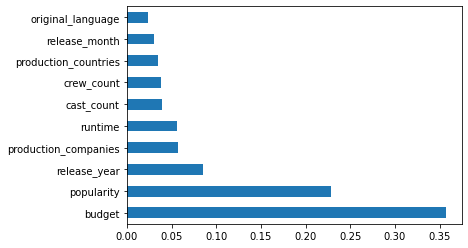

In [64]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train_full.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [65]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train_full, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
y_pred_xgb = xgb_model.predict(X_valid_full)

In [67]:
mae_xgb = mean_absolute_error(y_pred_xgb, y_valid)

print('MAE XGBoost: ', mae_xgb)

MAE XGBoost:  1.5005312711894054


<AxesSubplot:>

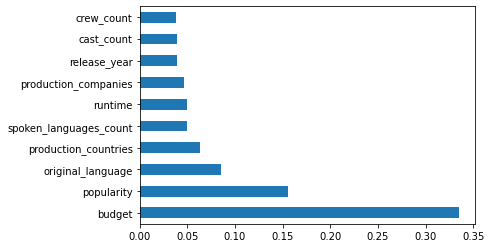

In [68]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train_full.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [69]:
X = train[feature_names]
X_test = test[feature_names]

In [70]:
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [72]:
y_pred_final = final_model.predict(X_test)
pred = pd.DataFrame(y_pred_final)

In [ ]:
datasets = pd.concat([submission['id'], pred], axis=1)
datasets.columns = ['id', 'revenue']
datasets.to_csv('f_submission.csv', index=False)